<a href="https://colab.research.google.com/github/kimhwijin/TensorflowWithKeras/blob/master/GAN/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, models, layers
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
np.random.seed(1000)

(X_train, _),(_,_) = datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
#단순 다층 퍼셉트로 MLP. multi-layer perceptron
X_train = X_train.reshape(60000, 784)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
#optimizer
adam = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

generator = models.Sequential()
#목적 : 노이즈 입력 수신 후 훈련 데이터셋과 유사한 이미지 생성.
#randomDim : 0 ~ 100 사이 임의 정수
randomDim = 10
generator.add(layers.Dense(256, input_dim=randomDim))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Dense(512))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Dense(1024))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Dense(784, activation='tanh'))
generator.summary()
#generator.compile(loss='binary_crossentropy', optimizer=adam)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2816      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

In [ ]:
#판별기
#입력 : 784 크기의 생성기 이미지
#출력 : 0 or 1 의 진짜 이미지 여부
discriminator = models.Sequential()
discriminator.add(layers.Dense(1024, input_dim=784))
discriminator.add(layers.LeakyReLU(0.2))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Dense(512))
discriminator.add(layers.LeakyReLU(0.2))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Dense(256))
discriminator.add(layers.LeakyReLU(0.2))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Dense(1, activation='sigmoid'))
discriminator.summary()
#판별기 먼저 따로 훈련
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

In [ ]:
#GAN에서 trainable 인수를 False로 판별기 가중치를 고정시킨다.
discriminator.trainable = False

#두 네트워크 합성, GAN 구성
ganInput = tf.keras.Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = models.Model(inputs=ganInput, outputs=ganOutput)
#나중에 판별기 가중치를 동결하고 결합된 GAN을 훈련한다.
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []

In [ ]:
#Plot the loss from each batch
def plotLoss(epoch):
  plt.figure(figsize=(10,8))
  plt.plot(dLosses, label='Discriminitive loss')
  plt.plot(gLosses, label='Generative loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

def saveGeneratedImages(epoch, examples=100, dim=(10,10), figsize=(10,10)):
  noise = np.random.normal(0,1, size=[examples, randomDim])
  generatedImages = generator.predict(noise)
  generatedImages = generatedImages.reshape(examples, 28, 28)

  plt.figure(figsize=figsize)
  for i in range(generatedImages.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
  plt.tight_layout()
  plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

In [ ]:
def train(epochs=1, batchSize=128):
  batchCount = int(X_train.shape[0] / batchSize)
  print('Epochs :', epochs)
  print('Batch Size : ', batchSize)
  print('Batches per epochs : ', batchCount)
  for e in range(1, epochs + 1):
    print('-' * 15, 'Epoch %d' % e, '-' * 15)
    for _ in range(batchCount):
      #랜덤 입력 노이즈와 이미지를 얻는다.
      #noise.shape = [batchSize, randomDim]
      noise = np.random.normal(0,1,size=[batchSize, randomDim])
      imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

      #가짜 MNIST 이미지 생성
      generatedImages = generator.predict(noise)
      #print(np.shape(imageBatch), np.shape(generatedImages))

      X = np.concatenate([imageBatch, generatedImages])

      #생성된 것과 실제 이미지의 레이블
      yDis = np.zeros(2*batchSize)
      #편파적 레이블 평활화
      yDis[:batchSize] = 0.9

      #판별기 훈련
      discriminator.trainable = True
      dloss = discriminator.train_on_batch(X, yDis)

      #생성기 훈련
      noise = np.random.normal(0,1, size=[batchSize, randomDim])
      yGen = np.ones(batchSize)
      discriminator.trainable = False
      gloss = gan.train_on_batch(noise, yGen)

    dLosses.append(dloss)
    gLosses.append(gloss)

    if e == 1 or e % 20 == 0:
      saveGeneratedImages(e)
      
  plotLoss(e)

Epochs : 100
Batch Size :  128
Batches per epochs :  468
--------------- Epoch 1 ---------------
--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------
--------------- Epoch 10 ---------------
--------------- Epoch 11 ---------------
--------------- Epoch 12 ---------------
--------------- Epoch 13 ---------------
--------------- Epoch 14 ---------------
--------------- Epoch 15 ---------------
--------------- Epoch 16 ---------------
--------------- Epoch 17 ---------------
--------------- Epoch 18 ---------------
--------------- Epoch 19 ---------------
--------------- Epoch 20 ---------------
--------------- Epoch 21 ---------------
--------------- Epoch 22 ---------------
--------------- Epoch 23 ---------------
---------

KeyboardInterrupt: ignored

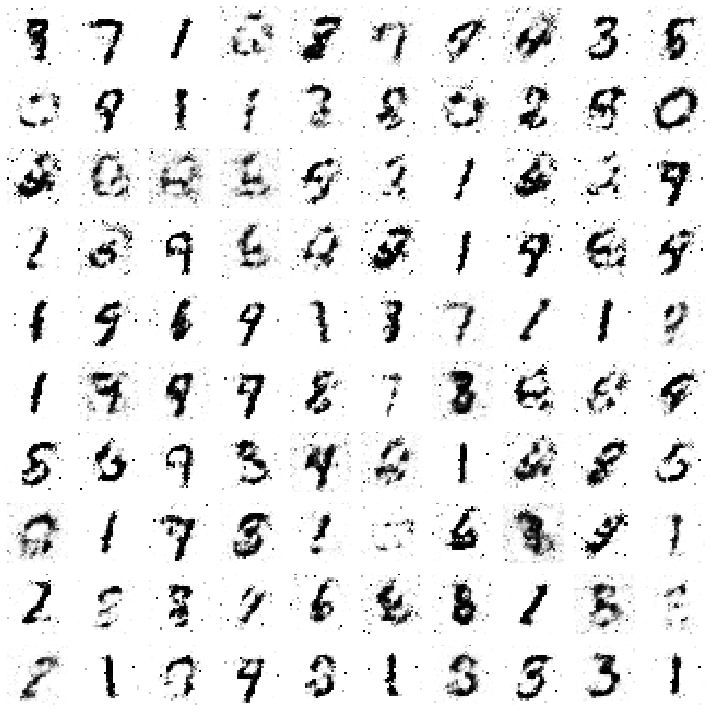

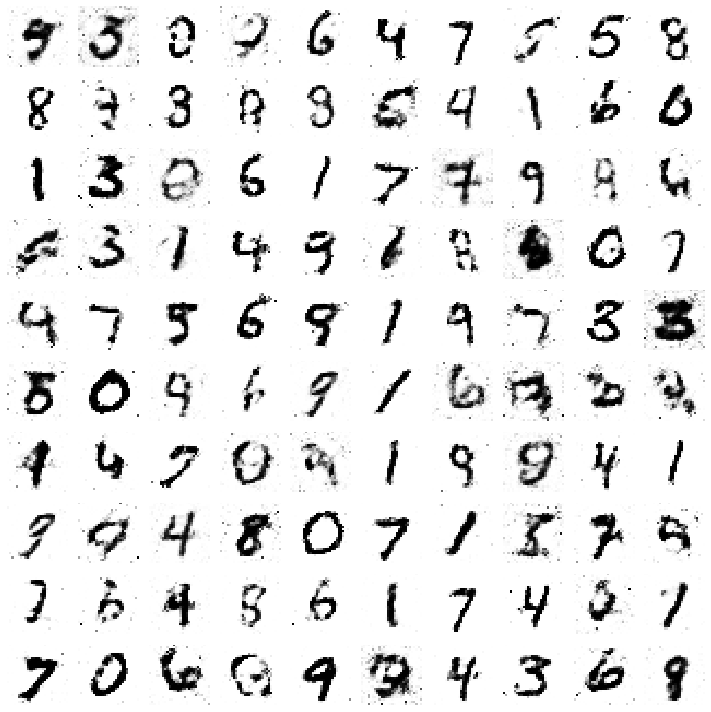

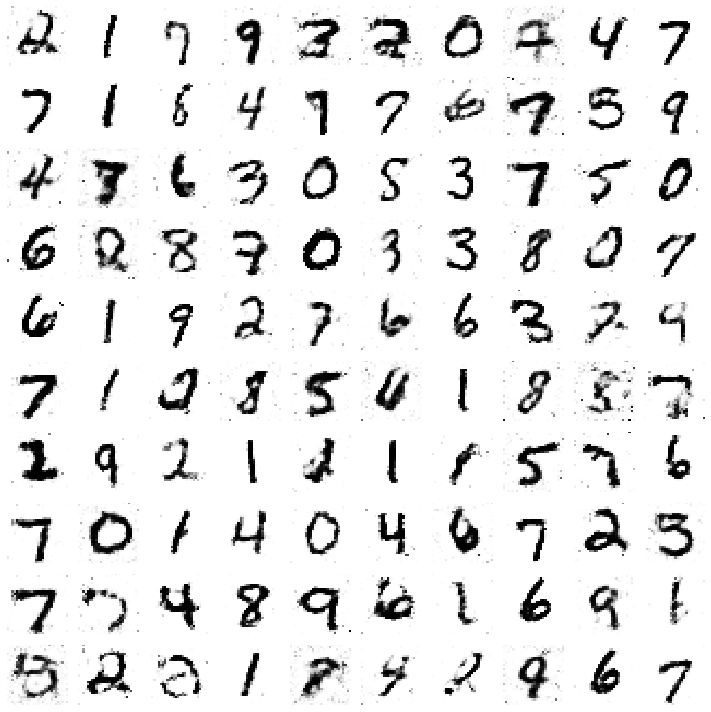

In [ ]:
train(100, 128)